Q. 사이킷런의 CountVectorizer는 중복을 알아서 제거하는가? 자체적으로 불필요하다고 판단하는 토큰을 제거하는 기준은? 
중복 허용(빈도 count)와 열에도 동시에 중복을 허용하는지가 헷갈리네.

Q. decoded이거 다르게 설정해야하는거 아녀? 

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

### 데이터  
- 로이터 뉴스 데이터를 사용하였으며, 46개의 클래스로 이루어져 있음
- 해당 뉴스가 어떤 카테고리에 속하는지를 예측

In [2]:
# 훈련 데이터, 테스트 데이터로 나눔
# num_words는 빈도수 기준으로 상위 몇번째 단어까지 사용할 것인지 지정
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

2121728/2110848 [==============================] - 0s 0us/step


In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


### 데이터 확인
- 텍스트가 아니라 숫자 시퀀스가 출력됨 -> 이미 전처리가 되어 있는 데이터임

In [4]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [5]:
print(y_train[0])
print(y_test[0])

3
3


In [6]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


### 데이터 분포도 살펴보기

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


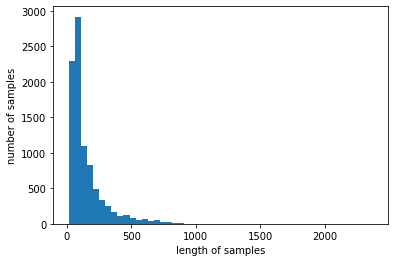

In [7]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples') 
plt.ylabel('number of samples')
plt.show()

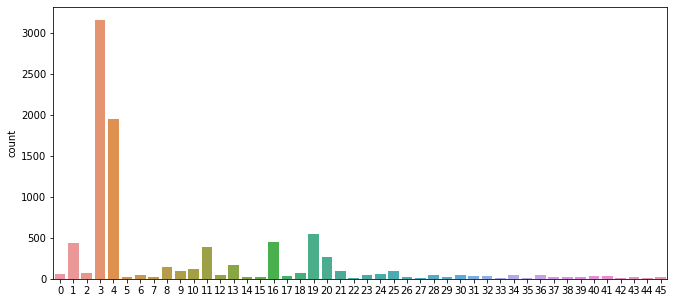

In [8]:
# 클래스 분포를 확인 -> 모든 클래스에 해당 데이터가 있는지, 어떤 클래스에 데이터가 많은지 확인
# 3, 4번이 대부분 차지
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [10]:
# 클래스별로 수치적으로 정확하게 출력
# 3번 : 3,159개, 4번:1,949개 존재
unique_elements, counts_elements = np.unique(y_train, return_counts=True) 
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


### 원본 데이터로 복구하기
- 수치형에서 텍스트로 복귀
- 로이터 뉴스 데이터는 단어를 key값으로 정수를 value로 가지는 딕셔너리 형태를 제공
- 즉, 단어장을 제공한다고 볼 수 있음

In [9]:
word_index = reuters.get_word_index(path = "reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [23]:
word_index # items()

{'mdbl': 10996,
 'fawc': 16260,
 'degussa': 12089,
 'woods': 8803,
 'hanging': 13796,
 'localized': 20672,
 'sation': 20673,
 'chanthaburi': 20675,
 'refunding': 10997,
 'hermann': 8804,
 'passsengers': 20676,
 'stipulate': 20677,
 'heublein': 8352,
 'screaming': 20713,
 'tcby': 16261,
 'four': 185,
 'grains': 1642,
 'broiler': 20680,
 'wooden': 12090,
 'wednesday': 1220,
 'highveld': 13797,
 'duffour': 7593,
 '0053': 20681,
 'elections': 3914,
 '270': 2563,
 '271': 3551,
 '272': 5113,
 '273': 3552,
 '274': 3400,
 'rudman': 7975,
 '276': 3401,
 '277': 3478,
 '278': 3632,
 '279': 4309,
 'dormancy': 9381,
 'errors': 7247,
 'deferred': 3086,
 'sptnd': 20683,
 'cooking': 8805,
 'stratabit': 20684,
 'designing': 16262,
 'metalurgicos': 20685,
 'databank': 13798,
 '300er': 20686,
 'shocks': 20687,
 'nawg': 7972,
 'tnta': 20688,
 'perforations': 20689,
 'affiliates': 2891,
 '27p': 20690,
 'ching': 16263,
 'china': 595,
 'wagyu': 16264,
 'affiliated': 3189,
 'chino': 16265,
 'chinh': 16266,
 '

In [10]:
# word_index에 해당 단어를 입력하면 맵핑되는 정수 출력
word_index['the']

1

In [11]:
word_index['it']

13

In [24]:
# 텍스트 데이터로 복구하는 것이 필요하기 때문에 word_index가 아니라 index_to_word가 필요
# 3을 더하는 이유는 <pad>, <sos>, <unk>라는 토큰들 때문에, 각각이 0, 1, 2를 나타냄.

index_to_word = { index+3 : word for word, index in word_index.items() }
index_to_word

{10999: 'mdbl',
 16263: 'fawc',
 12092: 'degussa',
 8806: 'woods',
 13799: 'hanging',
 20675: 'localized',
 20676: 'sation',
 20678: 'chanthaburi',
 11000: 'refunding',
 8807: 'hermann',
 20679: 'passsengers',
 20680: 'stipulate',
 8355: 'heublein',
 20716: 'screaming',
 16264: 'tcby',
 188: 'four',
 1645: 'grains',
 20683: 'broiler',
 12093: 'wooden',
 1223: 'wednesday',
 13800: 'highveld',
 7596: 'duffour',
 20684: '0053',
 3917: 'elections',
 2566: '270',
 3554: '271',
 5116: '272',
 3555: '273',
 3403: '274',
 7978: 'rudman',
 3404: '276',
 3481: '277',
 3635: '278',
 4312: '279',
 9384: 'dormancy',
 7250: 'errors',
 3089: 'deferred',
 20686: 'sptnd',
 8808: 'cooking',
 20687: 'stratabit',
 16265: 'designing',
 20688: 'metalurgicos',
 13801: 'databank',
 20689: '300er',
 20690: 'shocks',
 7975: 'nawg',
 20691: 'tnta',
 20692: 'perforations',
 2894: 'affiliates',
 20693: '27p',
 16266: 'ching',
 598: 'china',
 16267: 'wagyu',
 3192: 'affiliated',
 16268: 'chino',
 16269: 'chinh',
 2

In [25]:
# 옳게 출력되는 것을 확인
print(index_to_word[4]) 
print(index_to_word[16])

the
it


In [32]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

In [33]:
print(index_to_word[0]) 

<pad>


In [38]:
# 첫 번째 훈련용 뉴스 기사를 원래 텍스트로 복원
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### OOV(out of vocabulary) 문제와 UNK(unknown) 토큰
- num_words=10000는 정수 번호가 10,000이 넘는 단어들을 자동으로 \<unk> 토큰으로 처리
- 위에 전처리에서 \<unk>는 2로 처리 했기에 2로 출력 될 것

In [45]:
sample = [4, 587, 23, 133, 6, 30, 515]
print(' '.join([index_to_word[i] for i in sample]))

the transaction is expected to be completed


In [46]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [53]:
test_decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    test_decoded.append(t)

x_test = test_decoded
print(len(x_test))

KeyError: '<'

In [51]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [52]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

### 벡터화 하기
- 텍스트 데이터를 모델의 입력으로 넣기 위해서 벡터화를 진행
- 딥러닝을 모델을 사용할 경우에는 Word Embedding, Document Embedding, Contextual Embedding 등을 이용
- 해당 모델은 머신러닝을 방법을 적용할 것이기 때문에, Bag of Words 가설을 기반으로 하는 DTM, TF-IDF를 사용

In [54]:
#  DTM은 사이킷런의 CountVectorizer()를 통해서 생성
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer #  TF-IDF 행렬

=3


In [55]:
dtmvector = CountVectorizer() # DTM 생성
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

# 훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개가 됨
# num_words 개수를 10,000개로 지정했음에도 9,670개인 이유는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰들을 제거

(8982, 9670)


In [56]:
tfidf_transformer = TfidfTransformer() #  TF-IDF 행렬 : DTM의 단점을 보완, 가중치 부여
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


### 나이브 베이즈 분류기

In [57]:
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

In [ ]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

In [ ]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

66% 정확도

In [ ]:
x_test[3] # 확인

In [ ]:
y_test[3] # 확인

In [ ]:
# 모델 학습 결과에 따른 시각화
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [ ]:
model.predict(tfidfv_test[3])

모델은 4번 클래스를 약 90%의 확률로 확신하는데, 10%의 확률로 3번 클래스라고 판단합니다. 90%의 확률로 확신하므로 모델이 예측한 레이블은 4번입니다. 해당 샘플은 정확하게 예측했네요.

### 성능 비교

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
print(classification_report(y_test, model.predict(tfidfv_test), zero_division=0))

- macro: 단순평균
- weighted: 각 클래스에 속하는 표본의 개수로 가중평균
- accuracy: 정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율

In [ ]:
def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

In [ ]:
graph_confusion_matrix(model, tfidfv_test, y_test)

### 다양한 머신러닝 모델 사용해보기

#### Complement Naive Bayes Classifier(CNB)
- 데이터가 불균형 할 때의 나이브 베이즈 분류기의 단점을 보완하여 만든 분류기
- 데이터의 불균형을 고려하여 가중치를 부여하는 특징을 가짐
- 일반적으로 나이브 베이즈 분류기보다 성능이 좋음

In [ ]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

In [ ]:
predicted = cb.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
# 77% 

#### 로지스틱 회귀(Logistic Regression)
- 다중 클래스 분류를 시행할 때는 소프트맥스 회귀라고도 함
- 소프트맥스: 클래스가 N개 일때, N차원의 벡터가 각 클래스가 정답일 확률을 표현해주는 함수 

In [ ]:
# 10분 정도 소요됩니다.
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

In [ ]:
predicted = lr.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

#### 선형 서포트 벡터 머신(Linear Support Vector Machine)

In [ ]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

In [ ]:
predicted = lsvc.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

#### 결정 트리(Decision Tree)

In [ ]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

In [ ]:
predicted = tree.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교
# 62% 가장 낮음 -> 트리 계열보다 선형 분류 모델을 통해 접근하는 것이 더 나은 접근 방법인 것인 것을 알 수 있음

#### 랜덤 포레스트(Random Forest)
- 앙상블 모델 

In [ ]:
#estimator를 5로 설정하고 random_state를 0으로 설정한 RandomForestClassifier를 선언해주세요.
#참고자료 : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
forest = RandomForestClassifier(random_state=0)
forest.fit(tfidfv, y_train)

In [ ]:
predicted = forest.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

#### 그래디언트 부스팅 트리(GradientBoostingClassifier)
- 여러 개의 결정 트리를 묶어서 만든 앙상블 모델
- 랜덤 포레스트와 달리 이전 트리의 오차를 보완하는 방식을 적용
- 일부 특성을 무시하는 특징을 가지고 있음 
- 보통 랜덤 포레스트를 먼저 사용하고 이 후에 그래디언트 부스팅 트리를 시도

In [ ]:
# 15분 정도 소요될 수 있습니다.
grbt = GradientBoostingClassifier(random_state=0) # verbose=3
grbt.fit(tfidfv, y_train)

In [ ]:
predicted = grbt.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

#### 보팅(Voting)


In [ ]:
voting_classifier = VotingClassifier(estimators=[('lr', clf1), ('cb', cb), ('grbt', grbt)],
                 voting='soft')
voting_classifier.fit(tfidfv, y_train)

In [ ]:
predicted = voting_classifier.predict(tfidfv_test) #테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) #예측값과 실제값 비교

오늘의 실습 중 가장 높은 정확도를 보였던 소프트맥스 회귀보다 좀 더 높은 정확도를 얻었습니다.